# IMPORTS

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

np.random.seed(42)

# DEFINE STATIC FUNCTIONS

In [2]:
def z_score(df, scaler):
    """Z-scores the feature values based on the input scalar and returns the scaled features and the labels

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with labels in the first column and features in following columns
    scaler : sklearn.preprocessing.StandardScaler
        Scaler fit to the training dataset feature values

    Returns
    -------
    tuple
        np.array of scaled features and np.array of labels
    """
    features = df.iloc[:, 1:]
    labels = df.iloc[:, 0].values

    features = scaler.transform(features)
    return features, labels

def label_encoder(labels):
    unique_labels = sorted(np.unique(labels))
    labels_encoding = {i: l for i, l in enumerate(unique_labels)}
    return labels_encoding

def encode_labels(labels, encoder):
    return np.array([encoder[l] for l in labels])

def decode_labels(encoded_labels, encoder):
    decoder = {value: key for key, value in encoder.items()}
    return np.array([decoder[l] for l in encoded_labels])

def encoded_labels_array(encoded_labels):
    num_unique_labels = len(np.unique(encoded_labels))
    return np.array([np.array([1 if i == el else 0 for i in range(num_unique_labels)]) for el in encoded_labels])

In [3]:
def softmax(logits):
    """Performs the softmax operation on the input logits

    Parameters
    ----------
    logits : np.array
        Array of logits (raw output from output layer)

    Returns
    -------
    np.array
        Array of values after performing softmax (values sum to 1)
    """
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

def mcce(softmax_logits, labels):
    """Calculates multi-class cross entropy loss based on the softmaxed logits (class probabilities) and true labels

    Parameters
    ----------
    softmax_logits : np.array
        Array of softmaxed logits (class probabilities)
    labels : np.array
        Array of true labels 

    Returns
    -------
    np.float64
        Multi-class cross entropy loss
    """
    return - np.sum(labels * np.log(softmax_logits))

def sigmoid(unactivated):
    """Performs the sigmoid operation on the unactivated input matrix (output matrix from last layer @ weights)

    Parameters
    ----------
    unactivated : np.array
        Unactivated input matrix (output matrix from last layer @ weights)

    Returns
    -------
    np.array
        Matrix after performing sigmoid operation on unactivated input matrix
    """
    return 1 / (1 + np.exp(-unactivated))

def sigmoid_derivative(activated):
    """Performs the sigmoid derivative operation on the activated input matrix

    Parameters
    ----------
    activated : np.array
        Activated input matrix

    Returns
    -------
    np.array
        Matrix after performing sigmoid derivative operation on activated input matrix
    """
    return sigmoid(activated) * (1 - sigmoid(activated))

def relu(unactivated):
    """Performs the relu operation on the unactivated input matrix (output matrix from last layer @ weights)

    Parameters
    ----------
    unactivated : np.array
        Unactivated input matrix (output matrix from last layer @ weights)

    Returns
    -------
    np.array
        Matrix after performing relu operation on unactivated input matrix
    """
    return np.maximum(0, unactivated)

def relu_derivative(activated):
    """Performs the relu derivative operation on the activated input matrix

    Parameters
    ----------
    activated : np.array
        Activated input matrix

    Returns
    -------
    np.array
        Matrix after performing relu derivative operation on activated input matrix
    """
    return (activated > 0).astype(float)

# EXPLORE DOT PRODUCT RESULTS WITH MULTIPLE EXAMPLES

In [4]:
np.ones((2, 10))

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [5]:
np.ones((32, 2))

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [6]:
((np.ones((32, 2)) * 1) @ (np.ones((2, 32)) * 2)).shape

(32, 32)

In [7]:
((np.ones((32, 2)) * 1) @ (np.ones((2, 32)) * 2)) + np.ones(32)

array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]])

# TEST SOFTMAX AND MCCE 

In [8]:
arr = [[-2, 3, 2]]
sm = softmax(arr)
sm, sum(sm[0]), mcce(sm, [[0, 0, 1]]), mcce(sm, [[1, 0, 0]]), mcce(sm, [[0, 1, 0]])

(array([[0.00490169, 0.72747516, 0.26762315]]),
 np.float64(1.0),
 np.float64(1.318175429247454),
 np.float64(5.318175429247454),
 np.float64(0.31817542924745396))

# CREATE MODEL OBJECT

In [9]:
class model:
    """An object representing a trainable neural network with the follow architecture:
    Input Layer (input_size inputs)
        |
        v
    Weights (w_i_h) + Biases (b_i_h)
        |
        v
    ReLU Activation Function
        |
        v
    Hidden Layer (hidden_size hidden units)
        |
        v
    Weights (w_h_o) + Biases (b_h_o)
        |
        v
    Softmax Activation Function
        |
        v
    Output Layer (output_size outputs)
    """
    def __init__(self, input_size=2, hidden_size=9, output_size=2):
        """Initializes a neural network with specified input_size, hidden_size, and output_size (number of classes)
        by setting weights to values sampled from a normal distribution and biases to zero

        Parameters
        ----------
        input_size : int, optional
            Number of input features, by default 2
        hidden_size : int, optional
            Number of nodes in hidden layer, by default 9
        output_size : int, optional
            Number of output features (classes), by default 2
        """
        shape_i_h = (input_size, hidden_size) # shape of input to hidden layer weights matrix
        shape_h_o = (hidden_size, output_size) # shape of hidden to output layer weights matrix

        self.w_i_h = np.random.normal(loc=0.0, scale=1.0, size=shape_i_h) # randomly sample unique weights from a gaussian dist with mean 0 and std 1
        self.w_h_o = np.random.normal(loc=0.0, scale=1.0, size=shape_h_o) # randomly sample unique weights from a gaussian dist with mean 0 and std 1

        self.b_i_h = np.zeros(shape=(1, hidden_size)) # set biases to zero
        self.b_h_o = np.zeros(shape=(1, output_size)) # set biases to zero

        self.num_params = input_size * hidden_size + hidden_size * output_size + hidden_size + output_size # calculate number of params for fun

    def forward(self, features, train=False):
        """Perform a forward pass through the neural network

        Parameters
        ----------
        features : np.array
            Array of examples with each example being an array of feature values
        train : bool, optional
            True if training the network (i.e., if intermediate results are needed to compute gradients), by default False

        Returns
        -------
        np.array
            Array of outputs for each example with each output being an array of class probabilities
        """
        forward_results = {}

        forward_results['features'] = features
        i_h = features @ self.w_i_h
        forward_results['i_h'] = i_h
        i_h_b = i_h + self.b_i_h
        forward_results['i_h_b'] = i_h_b
        a_i_h_b = relu(i_h_b)
        forward_results['a_i_h_b'] = a_i_h_b        

        h_o = a_i_h_b @ self.w_h_o
        forward_results['h_o'] = h_o        
        h_o_b = h_o + self.b_h_o
        forward_results['h_o_b'] = h_o_b
        a_h_o_b = softmax(h_o_b)
        forward_results['a_h_o_b'] = a_h_o_b

        if train:
            return a_h_o_b, forward_results
        return a_h_o_b

    def backward(self, forward_results, labels):
        gradients = {}
        
        probs = forward_results['a_h_o_b']
        
        dL_dh_o_b = probs - labels
        
        a_i_h_b = forward_results['a_i_h_b']
        gradients['w_h_o'] = a_i_h_b.T @ dL_dh_o_b
        gradients['b_h_o'] = np.sum(dL_dh_o_b, axis=0, keepdims=True)

        dL_da_i_h_b = dL_dh_o_b @ self.w_h_o.T 
        dL_di_h_b = dL_da_i_h_b * relu_derivative(forward_results['a_i_h_b'])

        gradients['w_i_h'] = forward_results['features'].T @ dL_di_h_b 
        gradients['b_i_h'] = np.sum(dL_di_h_b, axis=0, keepdims=True)

        return gradients
        
    def update_weights(self, gradients, learning_rate):
        self.w_h_o -= (learning_rate * gradients['w_h_o'])
        self.b_h_o -= (learning_rate * gradients['b_h_o'])
        self.w_i_h -= (learning_rate * gradients['w_i_h'])
        self.b_i_h -= (learning_rate * gradients['b_i_h'])

    def train(self, features, encoded_labels, valid_features, encoded_valid_labels, num_epochs, learning_rate):
        encoded_labels_arr = encoded_labels_array(encoded_labels)
        encoded_valid_labels_arr = encoded_labels_array(encoded_valid_labels)

        train_loss = []
        valid_loss = []
        
        for i in range(num_epochs):
            probs, forward_results = self.forward(features, train=True)
            
            gradients = self.backward(forward_results, encoded_labels_arr)
            # for k, v in gradients.items():
            #     print(f'{k}: {v.shape}')
            
            self.update_weights(gradients, learning_rate)
            
            loss = mcce(forward_results['a_h_o_b'], encoded_labels_arr)
            train_loss.append(loss)

            probs, forward_results = self.forward(valid_features, train=True)
                                    
            loss = mcce(forward_results['a_h_o_b'], encoded_valid_labels_arr)
            valid_loss.append(loss)
        
        return train_loss, valid_loss
    
    def predict(self, features):
        y_predicted = self.forward(features)
        predicted_labels = np.array([np.argmax(y_p) for y_p in y_predicted])
        return predicted_labels
    
    def accuracy(self, test_features, encoded_test_labels):
        test_results = self.predict(test_features)
        acc = np.sum([test_result == encoded_test_label for test_result, encoded_test_label in zip(test_results, encoded_test_labels)]) / len(encoded_test_labels)
        return acc
    
    def decision_boundary(self, train_features, encoded_train_labels):
        x_min, x_max = train_features[:, 0].min() - 1, train_features[:, 0].max() + 1
        y_min, y_max = train_features[:, 1].min() - 1, train_features[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

        # Predict labels for all points in the meshgrid
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(grid_points)
        Z = Z.reshape(xx.shape)

        # Plot decision boundary
        plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')

        # Scatter plot of training points
        plt.scatter(train_features[:, 0], train_features[:, 1], c=encoded_train_labels, edgecolor='k', cmap='coolwarm', marker='o')

        plt.title("Decision Boundary with Training Data Points")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.show()

In [10]:
i = np.ones((1, 2))
i_multiple = np.ones((16, 2))

In [11]:
m = model()
m.forward(i), m.forward(i_multiple).shape

(array([[0.05434576, 0.94565424]]), (16, 2))

In [12]:
_, results = m.forward(i_multiple, True)
m.backward(results, np.ones((16, 2)))

{'w_h_o': array([[-15.72470473,  -0.90368242],
        [  0.        ,   0.        ],
        [ -2.75312152,  -0.15821903],
        [-26.70515649,  -1.53471756],
        [  0.        ,   0.        ],
        [  0.        ,   0.        ],
        [-15.38655526,  -0.88424932],
        [  0.        ,   0.        ],
        [  0.        ,   0.        ]]),
 'b_h_o': array([[-15.13046776,  -0.86953224]]),
 'w_i_h': array([[14.9668726 ,  0.        ,  0.21713116,  8.1403145 ,  0.        ,
          0.        ,  7.4934869 ,  0.        ,  0.        ],
        [14.9668726 ,  0.        ,  0.21713116,  8.1403145 ,  0.        ,
          0.        ,  7.4934869 ,  0.        ,  0.        ]]),
 'b_i_h': array([[14.9668726 ,  0.        ,  0.21713116,  8.1403145 ,  0.        ,
          0.        ,  7.4934869 ,  0.        ,  0.        ]])}

In [13]:
# csv_file_prefix = 'spiral'
# csv_file_prefix = 'two_gaussians'
csv_file_prefix = 'xor'
# csv_file_prefix = 'center_surround'

In [14]:
scaler = StandardScaler()  # z-score all input features

train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')

train_features = train_df.iloc[:, 1:]
features = scaler.fit(train_features)

valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

train_features, train_labels = z_score(train_df, scaler)
train_labels_encoder = label_encoder(train_labels)
encoded_train_labels = encode_labels(train_labels, train_labels_encoder)

valid_features, valid_labels = z_score(valid_df, scaler)
valid_labels_encoder = label_encoder(valid_labels)
encoded_valid_labels = encode_labels(valid_labels, valid_labels_encoder)

test_features, test_labels = z_score(test_df, scaler)
test_labels_encoder = label_encoder(test_labels)
encoded_test_labels = encode_labels(test_labels, test_labels_encoder)

In [15]:
train_features

array([[-7.70456523e-01,  8.76493383e-01],
       [ 7.06498327e-01,  2.66823092e-02],
       [-4.56966795e-01, -1.66068960e+00],
       [ 1.68092581e+00, -1.68531209e-01],
       [-3.96545074e-01, -1.35917560e+00],
       [-1.33322055e+00, -1.18451087e+00],
       [-1.75862370e-01,  6.91257884e-01],
       [-6.22362236e-02,  5.17778665e-01],
       [-1.72748847e+00, -1.47515772e+00],
       [ 8.49271246e-01,  1.25111366e+00],
       [-1.04711954e+00,  1.80711653e+00],
       [-2.73851043e-01,  9.60170433e-01],
       [-1.17198708e-01,  7.72069958e-01],
       [ 1.47597311e+00, -5.34382187e-02],
       [-1.54488071e-01,  1.93716815e-02],
       [ 1.03007376e+00, -6.83535293e-01],
       [-8.63726194e-01, -4.66291099e-01],
       [ 1.03627323e+00,  1.16911608e+00],
       [-1.39358583e-02,  1.66870857e+00],
       [ 6.97245383e-01,  1.46312186e+00],
       [-1.07298059e-01,  9.51453497e-02],
       [ 1.30044477e+00, -4.50583129e-01],
       [ 8.88133608e-01, -1.18470846e+00],
       [-1.

In [16]:
encoded_labels_array(encoded_train_labels)

array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0,

In [17]:
m = model(input_size=len(train_features[0]), hidden_size=9, output_size=len(np.unique(train_labels)))

num_epochs = 1000
learning_rate = 0.001
train_loss, valid_loss = m.train(train_features, encoded_train_labels, valid_features, encoded_valid_labels, num_epochs, learning_rate)

In [21]:
m.w_i_h

array([[ 0.62268942, -2.48306952, -2.73733111,  1.20375877,  1.76327787,
         1.50892904, -1.41698508,  0.31539976, -1.47657769],
       [-1.0301463 , -1.86657459,  2.11993747,  1.4571912 , -2.64876249,
         1.79880861, -1.74424799, -0.60865849,  0.75577253]])

In [22]:
m.b_i_h

array([[-0.07484406,  0.15651141,  0.29716566, -0.08135512, -0.20764713,
        -0.10169835,  0.06780483, -0.03934066,  0.15480648]])

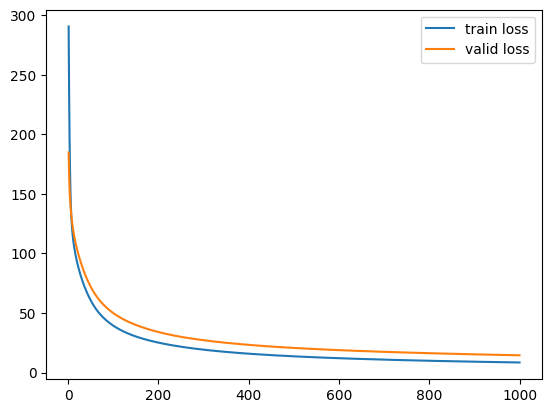

In [19]:
plt.plot(range(1, num_epochs + 1), train_loss, label='train loss')
plt.plot(range(1, num_epochs + 1), valid_loss, label='valid loss')
plt.legend()

plt.show()

In [18]:
m.accuracy(test_features, encoded_test_labels)

np.float64(0.995)

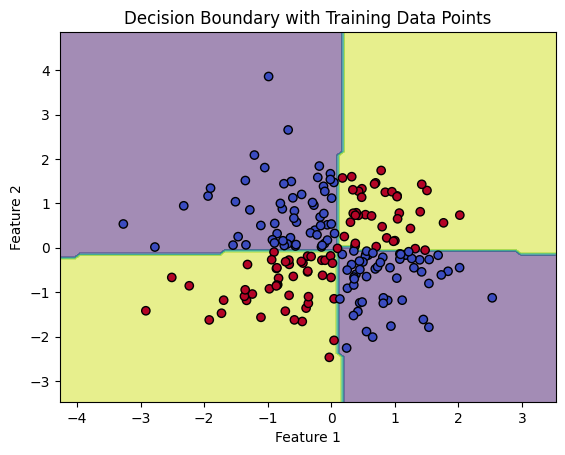

In [20]:
m.decision_boundary(train_features, encoded_train_labels)